In [1]:
#Import liberaries
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from scipy.stats import skew, kurtosis

In [4]:
from xgboost import XGBClassifier

In [5]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
from scipy.stats import randint

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
# Load dataset
dfb = pd.read_csv("sensor_raw_modified.csv")

In [9]:
#Data exploration
print(dfb.shape)
print(dfb.columns)
print(dfb.dtypes)
dfb.head()

(1314, 7)
Index(['Target(Class)', 'GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ'], dtype='object')
Target(Class)      int64
GyroX            float64
GyroY            float64
GyroZ            float64
AccX             float64
AccY             float64
AccZ             float64
dtype: object


,Target(Class),GyroX,GyroY,GyroZ,AccX,AccY,AccZ
0,1,-0.923664,3.694656,0.824427,0.162598,-0.086670,-0.969482
1,1,-0.908397,4.534351,0.832061,0.175781,-0.100586,-1.013184
2,1,0.786260,3.969466,0.587786,0.322754,-0.140381,-0.911621
3,1,0.335878,4.564885,-0.251908,0.480225,-0.226807,-0.936768
4,1,3.351145,2.694656,-0.106870,0.426025,-0.253906,-0.950195


In [11]:
dfb.describe()

,Target(Class),GyroX,GyroY,GyroZ,AccX,AccY,AccZ
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,2.491629,-0.709061,3.502817,2.404843,0.214590,-0.079632,-0.695399
std,1.061838,3.433748,3.516913,11.528901,0.194480,0.183278,41.058925
min,1.000000,-14.946565,-10.351145,-50.259542,-0.284854,-0.793457,-165.157441
25%,2.000000,-2.274809,1.238550,0.480916,0.064026,-0.164490,-1.031372
50%,3.000000,-0.595420,4.080153,1.160305,0.195923,-0.089722,-0.979126
75%,3.000000,0.814885,5.427481,5.068702,0.352112,0.008218,-0.897583
max,4.000000,12.778626,16.793893,45.442748,0.747803,0.768555,172.706929


In [13]:
#Missing value 
dfb.isnull().sum()

Target(Class)    0
GyroX            0
GyroY            0
GyroZ            0
AccX             0
AccY             0
AccZ             0
dtype: int64

<Axes: title={'center': 'Class Distribution'}, xlabel='Target(Class)'>

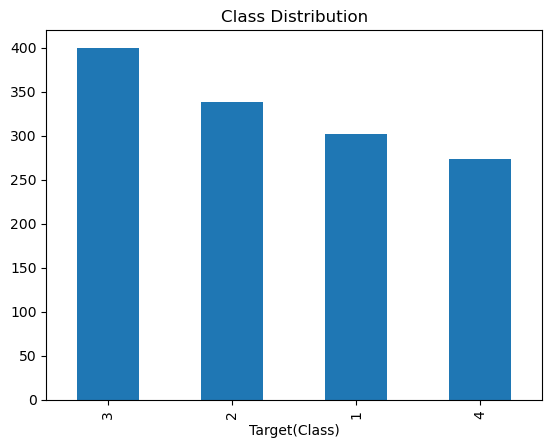

In [41]:
#check for class distribution
dfb['Target(Class)'].value_counts().plot(kind='bar', title='Class Distribution')

In [19]:
#Data preprocessing 
# Define windowing parameters
#Segment data into fixed-size windows (e.g., 14 seconds → ~28 samples)
window_size_c =28
step_size_c = 14

In [25]:
# Sliding window
def feature_engineering(window_size_c,axes,features):
    for start in range(0, len(dfb) - window_size_c + 1, step_size_c):
        end = start + window_size_c
        window_c = dfb.iloc[start:end]
        #print(window)
        row_features_c = {}
    
        for axis in axes:
            data_c = window_c[axis]
            row_features_c[f'{axis}_mean'] = data_c.mean()
            row_features_c[f'{axis}_std'] = data_c.std()
            row_features_c[f'{axis}_max'] = data_c.max()
            row_features_c[f'{axis}_min'] = data_c.min()
            row_features_c[f'{axis}_skew'] = skew(data_c)
            row_features_c[f'{axis}_kurtosis'] = kurtosis(data_c)

        # Assign label as the most frequent in the window
        row_features_c['Target'] = window_c['Target(Class)'].mode()[0]
    
        features.append(row_features_c)

    # Final dataset
    feature_df_c = pd.DataFrame(features)
    feature_df_c.to_csv("behavior_data.csv", index=False)
    print(" Feature set saved to 'behavior_data.csv'")

# Axes to extract features from
axes = ['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']
features = []

feature_engineering(window_size,axes,features)

 Feature set saved to 'behavior_data.csv'


In [27]:
df_r = pd.read_csv("behavior_data.csv")
# Prepare features and labels
X_r = df_r.drop(columns='Target')
y_r = df_r['Target']

In [28]:
print(df_r['Target'].value_counts())

Target
3    27
1    24
2    23
4    18
Name: count, dtype: int64


In [30]:
X_trainBH, X_testBH, y_trainBH, y_testBH = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42 , stratify=y)


In [31]:
# Now both X_train and y_train should have same number of rows
print(X_testBH.shape, y_testBH.shape)

(19, 36) (19,)


In [32]:
# Train Random Forest Classifier
RandomFC = RandomForestClassifier(n_estimators=120, random_state=42)
RandomFC.fit(X_trainBH, y_trainBH)

RandomForestClassifier(n_estimators=120, random_state=42)

In [34]:
# Predict and evaluate
y_predBH = RandomFC.predict(X_testBH)
print(classification_report(y_testBH, y_predBH))

              precision    recall  f1-score   support

           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.80      0.80      0.80         5
           4       0.75      0.75      0.75         4

    accuracy                           0.79        19
   macro avg       0.82      0.79      0.78        19
weighted avg       0.82      0.79      0.79        19



In [35]:
from sklearn.model_selection import RandomizedSearchCV
##Hyperparameter Tuning
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rfBH = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_searchBH = RandomizedSearchCV(rfBH, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchBH.fit(X_trainBH, y_trainBH)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025413E3F210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025413E6AB50>})

In [36]:
# Create a variable for the best model
best_rf = rand_searchBH.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchBH.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 156}


In [38]:
# Train Random Forest with max_depth
rnclf_H = RandomForestClassifier(n_estimators=156, max_depth=11, random_state=42)
rnclf_H.fit(X_trainBH, y_trainBH)

# Evaluate
y_pred_H = rnclf_H.predict(X_testBH)
print(classification_report(y_testBH, y_pred_H))

              precision    recall  f1-score   support

           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.80      0.80      0.80         5
           4       0.75      0.75      0.75         4

    accuracy                           0.79        19
   macro avg       0.82      0.79      0.78        19
weighted avg       0.82      0.79      0.79        19



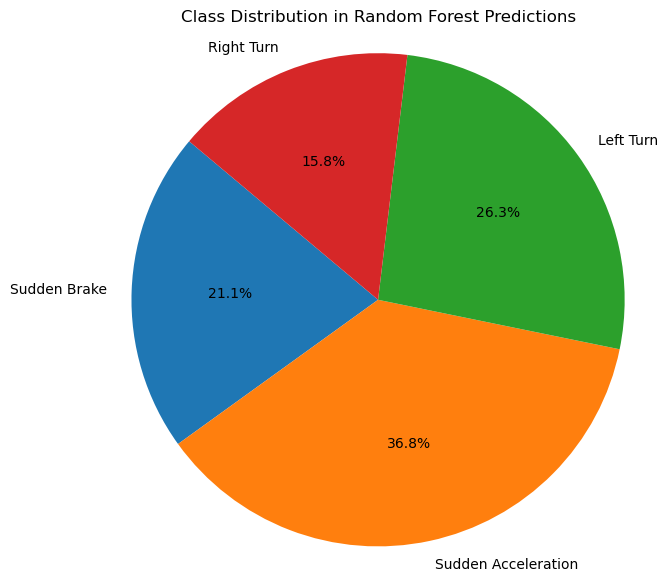

In [42]:
import matplotlib.pyplot as plt
from collections import Counter
#y_pred = [1, 2, 2, 3, 1, 4, 2, 3, 1, 1, 4, 4, 2]

# Count occurrences of each class label
class_counts = Counter(y_pred_H)

# Map class labels to behavior names
label_map = {
    1: 'Sudden Acceleration',
    2: 'Right Turn',
    3: 'Left Turn',
    4: 'Sudden Brake'
}

labels = [label_map[k] for k in class_counts.keys()]
sizes = list(class_counts.values())

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Random Forest Predictions')
plt.axis('equal')
plt.show()

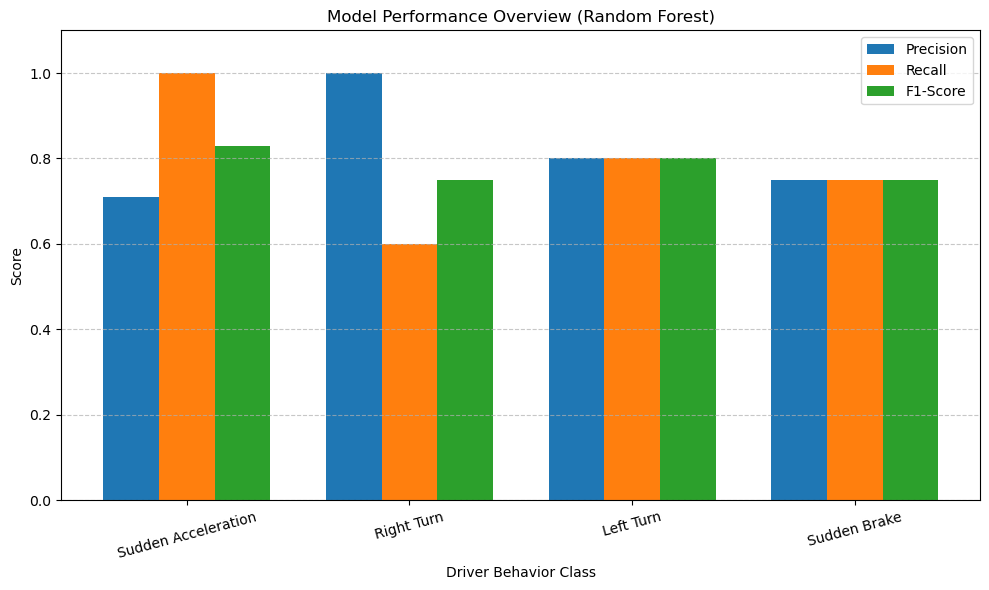

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
classes = ['Sudden Acceleration', 'Right Turn', 'Left Turn', 'Sudden Brake']

# Metrics (replace these with your actual values)
precision = [0.71, 1.00, 0.80, 0.75]
recall    = [1.00, 0.60, 0.80, 0.75]
f1_score  = [0.83, 0.75, 0.80, 0.75]

# Bar width and positions
x = np.arange(len(classes))
width = 0.25

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

# Labeling
plt.xlabel('Driver Behavior Class')
plt.ylabel('Score')
plt.title('Model Performance Overview (Random Forest)')
plt.xticks(x, classes, rotation=15)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

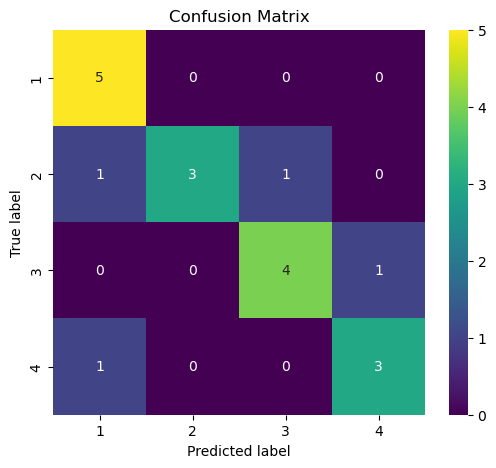

In [44]:
# Create the confusion matrix
# Create the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Explicitly define the class labels: [1, 2, 3, 4]
labels = [1, 2, 3, 4]
cm = confusion_matrix(y_testBH, y_pred_H, labels=labels)

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='viridis',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()